Analyzing Soccer Player Faces
--------------------------------

In this script we will explore a dataset of faces of approximately 450 top male soccer players and approximately 150 top female soccer players.
We will examine the main modes of variation in the appearance of player faces (the face images of the players are conveniently almost perfectly aligned so the images turn out particularly nice).

We then try to find correlations between face features and real life attributes of those players such as "Age", "Height", "Weight" and "Sex".

Note that the first part of this script is essentially the same code that I used in [Visualizing PCA][1], but the data here is more interesting since it contains human faces. I welcome everyone to go visit also the [Visualizing PCA][1] script and look at the difference when applying the same piece of code to a different dataset.

  [1]: https://www.kaggle.com/selfishgene/leaf-classification/visualizing-pca-with-leaf-dataset

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob

from sklearn import decomposition
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE

matplotlib.style.use('fivethirtyeight')

## Load the data 

In [2]:
#%% load the data, go over training images and store them in a list
maleFaceFiles   = glob.glob('../input/Pictures/*.png')
femaleFaceFiles = glob.glob('../input/Pictures_f/*.png')
faceFiles = maleFaceFiles + femaleFaceFiles

listOfPlayerNames = []
listOfImages = []
for imageFilename in faceFiles:
    currName = imageFilename.split("/")[-1].split('.')[0]
        
    try:
        currImage = mpimg.imread(imageFilename)
        if len(np.unique(currImage[:,:,0].ravel())) <= 40:
            print("no image for '" + currName + "'")
        else:
            listOfPlayerNames.append(currName)
            listOfImages.append(currImage)
    except:
        print("didn't load '" + currName + "'")
        
femaleNames = [x.split("/")[-1].split('.')[0] for x in femaleFaceFiles]
isFemale    = [x in femaleNames for x in listOfPlayerNames]

print('Total number of loaded face images is %d' %(len(listOfImages)))

Total number of loaded face images is 572


## Show a random sample of players in the dataset

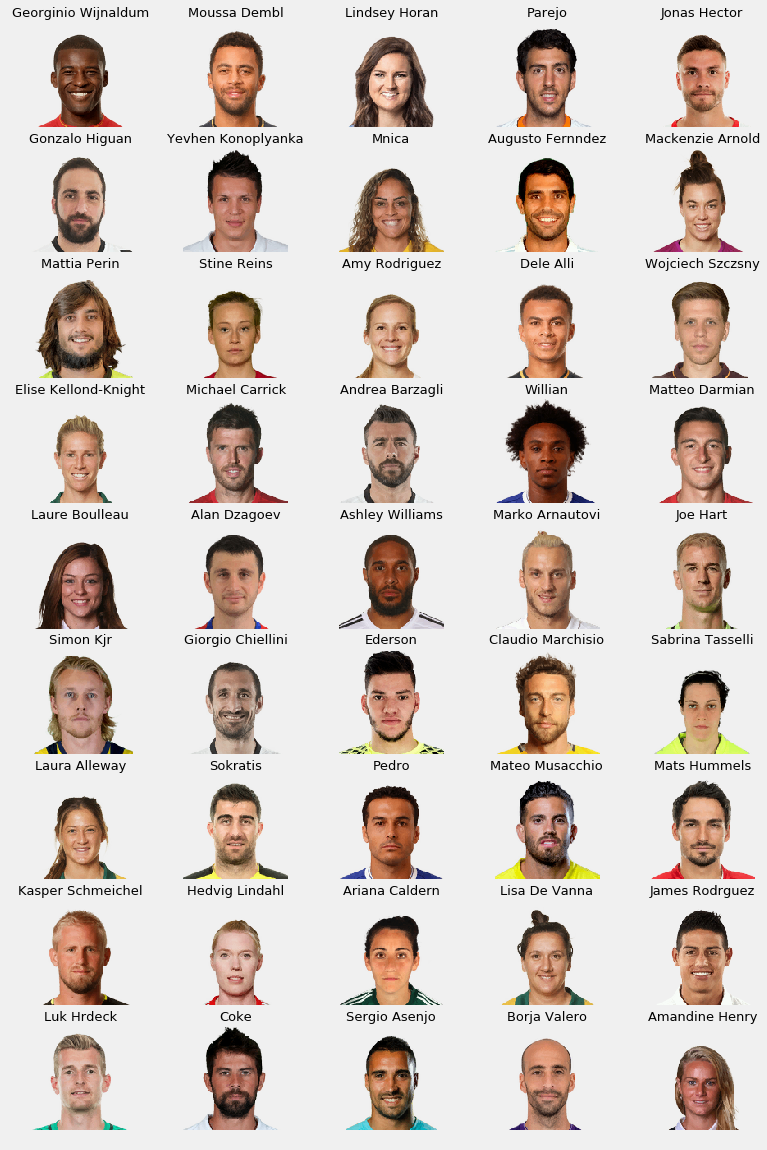

In [3]:
#%% show some images
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (12,19)

numRows = 9; numCols = 5

plt.figure()
for k in range(numRows*numCols):
    randInd = np.random.randint(len(listOfImages))
    plt.subplot(numRows,numCols,k+1); 
    plt.imshow(listOfImages[randInd])
    plt.title(listOfPlayerNames[randInd]); plt.axis('off')

## Reorganize the Data for later

In [4]:
#%% gather everything into a large matrix
fullImageMatrix4D = np.zeros((128,128,3,len(listOfImages)))

backGroundImage = np.zeros((128,128,3))
backGroundImage[:,:,0] = 0.3
backGroundImage[:,:,1] = 0.4
backGroundImage[:,:,2] = 0.5

for k, currImage in enumerate(listOfImages):
    alphaChannel = currImage[:,:,3]
    rgbImage = currImage[:,:,:3]
    tiledAlpha = np.tile(alphaChannel[:,:,np.newaxis],(1,1,3))
    
    fullImageMatrix4D[:,:,:,k] = rgbImage*tiledAlpha + (tiledAlpha < 0.15)*backGroundImage

## Show the Mean Face Image and pixel-wise Standard Deviation Image

(-0.5, 127.5, 127.5, -0.5)

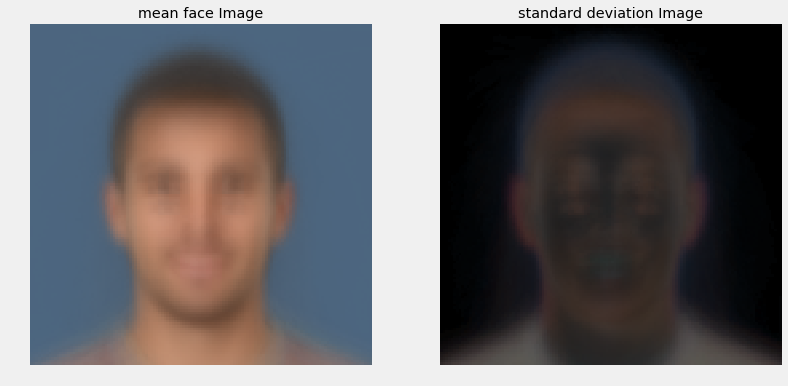

In [5]:
# show mean face image and stdev image
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12,12)

plt.figure(); 
plt.subplot(1,2,1); plt.imshow(fullImageMatrix4D.mean(axis=3)); 
plt.title('mean face Image'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(fullImageMatrix4D.std(axis=3)); 
plt.title('standard deviation Image'); plt.axis('off')

## Define a Gaussian Model class that will later help us visualize things:

(this is long, just skip this to get to the analysis)

In [6]:
#%% define GaussianModel class and some additional helper functions

class GaussianModel:

    def __init__(self, X, numBasisFunctions=10, objectPixels=None):
        '''
        inputs: 
            X                    - numSamples x numDimentions matrix
            numBasisFunctions       - number of basis function to use
            objectPixels (optional) - an binnary mask image used for presentation
                                      will be used as Im[objectPixels] = dataSample
                                      must satisfy objectPixels.ravel().sum() = X.shape[1]
        '''
        
        self.numBasisFunctions = numBasisFunctions
        if objectPixels is None:
            self.objectPixels = np.ones((1,X.shape[1]),dtype=np.bool)
        else:
            self.objectPixels = objectPixels
        assert(self.objectPixels.ravel().sum() == X.shape[1])

        PCAModel = decomposition.PCA(n_components=numBasisFunctions, whiten=True)
        #PCAModel = decomposition.IncrementalPCA(n_components=numBasisFunctions, whiten=True, batch_size=400)
        self.dataRepresentation = PCAModel.fit_transform(X)
        self.PCAModel = PCAModel

        
    def RepresentUsingModel(self, X):
        return self.PCAModel.transform(X)

    def ReconstructUsingModel(self, X_transformed):
        return self.PCAModel.inverse_transform(X_transformed)

    def InterpretUsingModel(self, X):
        return self.PCAModel.inverse_transform(self.PCAModel.transform(X))

        
    # shows the eigenvectors of the gaussian covariance matrix
    def ShowVarianceDirections(self, numDirectionsToShow=16):
        #matplotlib.rcParams['font.size'] = 14
        numDirectionsToShow = min(numDirectionsToShow, self.numBasisFunctions)
        
        numFigRows = 4; numFigCols = 4;
        numDirectionsPerFigure = numFigRows*numFigCols
        numFigures = int(np.ceil(float(numDirectionsToShow)/numDirectionsPerFigure))
        
        for figureInd in range(numFigures):
            plt.figure()
            for plotInd in range(numDirectionsPerFigure):
                eigVecInd = numDirectionsPerFigure*figureInd + plotInd
                if eigVecInd >= self.numBasisFunctions:
                    break
                deltaImage = np.zeros(np.shape(self.objectPixels))
                deltaImage[self.objectPixels] = self.PCAModel.components_[eigVecInd,:].ravel()

                plt.subplot(numFigRows,numFigCols,plotInd+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(deltaImage)
                elif np.shape(self.objectPixels)[2] == 3:
                    deltaImage = 0.1/deltaImage.std()*deltaImage+0.5
                    deltaImage[deltaImage>1] = 1.0
                    deltaImage[deltaImage<0] = 0.0
                    plt.imshow(deltaImage); plt.axis('off')
                else:
                    plt.imshow(deltaImage); plt.axis('off')
                plt.title('%.3f%s explained' %(100*self.PCAModel.explained_variance_ratio_[eigVecInd], '%'))
            plt.tight_layout()

    
    # shows several random model reconstructions
    def ShowReconstructions(self, X, numReconstructions=6):
        #matplotlib.rcParams['font.size'] = 14
        assert(np.shape(X)[1] == self.objectPixels.ravel().sum())
        numSamples = np.shape(X)[0]
        numReconstructions = min(numReconstructions, numSamples)
        
        originalImage      = np.zeros(np.shape(self.objectPixels))
        reconstructedImage = np.zeros(np.shape(self.objectPixels))
        
        numReconstructionsPerFigure = min(6, numReconstructions)
        numFigures = int(np.ceil(float(numReconstructions)/numReconstructionsPerFigure))
        
        for figureInd in range(numFigures):
            plt.figure()
            for plotCol in range(numReconstructionsPerFigure):
                dataSampleInd = np.random.randint(numSamples)
                originalImage[self.objectPixels] = X[dataSampleInd,:].ravel()
                reconstructedImage[self.objectPixels] = self.InterpretUsingModel(np.reshape(X[dataSampleInd,:],[1,-1])).ravel()
                diffImage = abs(originalImage - reconstructedImage)
                
                # original image
                plt.subplot(3,numReconstructionsPerFigure,0*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(originalImage); plt.title('original signal')
                else:
                    plt.imshow(originalImage, cmap='gray'); plt.title('original image'); plt.axis('off')
                    
                # reconstred image
                plt.subplot(3,numReconstructionsPerFigure,1*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(reconstructedImage); plt.title('reconstructed signal')
                elif np.shape(self.objectPixels)[2] == 3:
                    reconstructedImage[reconstructedImage>1] = 1.0
                    reconstructedImage[reconstructedImage<0] = 0.0
                    plt.imshow(reconstructedImage); plt.title('reconstructed image'); plt.axis('off')
                else:
                    plt.imshow(reconstructedImage, cmap='gray'); plt.title('reconstructed image'); plt.axis('off')

                # diff image
                plt.subplot(3,numReconstructionsPerFigure,2*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(diffImage); plt.title('abs difference signal')
                else:
                    plt.imshow(diffImage, cmap='gray'); plt.title('abs difference image'); plt.axis('off')
            plt.tight_layout()

            
    # shows distrbution along the variance directions and several images along that variance direction
    def ShowModelVariations(self, numVariations=6):
        #matplotlib.rcParams['font.size'] = 14

        showAsTraces = (np.shape(self.objectPixels)[0] == 1)
        numVariations = min(numVariations, self.numBasisFunctions)
                
        numVarsPerFigure = min(6,numVariations)
        numFigures = int(np.ceil(float(numVariations)/numVarsPerFigure))
        
        lowRepVec     = np.percentile(self.dataRepresentation, 2, axis=0)
        medianRepVec  = np.percentile(self.dataRepresentation, 50, axis=0)
        highRepVec    = np.percentile(self.dataRepresentation, 98, axis=0)

        for figureInd in range(numFigures):
            plt.figure()
            for plotCol in range(numVarsPerFigure):
                eigVecInd = numVarsPerFigure*figureInd+plotCol
                if eigVecInd >= self.numBasisFunctions:
                    break

                # create the low and high precentile representation activation vectors
                currLowPrecentileRepVec             = medianRepVec.copy()
                currLowPrecentileRepVec[eigVecInd]  = lowRepVec[eigVecInd]
                currHighPrecentileRepVec            = medianRepVec.copy()
                currHighPrecentileRepVec[eigVecInd] = highRepVec[eigVecInd]

                # create blank images
                deltaImage          = np.zeros(np.shape(self.objectPixels))
                medianImage         = np.zeros(np.shape(self.objectPixels))
                lowPrecentileImage  = np.zeros(np.shape(self.objectPixels))
                highPrecentileImage = np.zeros(np.shape(self.objectPixels))

                # fill the object pixels with the relevant data
                deltaImage[self.objectPixels]          = self.PCAModel.components_[eigVecInd,:].ravel()
                lowPrecentileImage[self.objectPixels]  = self.ReconstructUsingModel(currLowPrecentileRepVec).ravel()
                medianImage[self.objectPixels]         = self.ReconstructUsingModel(medianRepVec).ravel()
                highPrecentileImage[self.objectPixels] = self.ReconstructUsingModel(currHighPrecentileRepVec).ravel()

                # calculate the Gaussian smoothed distribution of values along the eignevector direction
                sigmaOfKDE = 0.12
                pdfStart   = min(self.dataRepresentation[:,eigVecInd]) - 3*sigmaOfKDE
                pdfStop    = max(self.dataRepresentation[:,eigVecInd]) + 3*sigmaOfKDE
                xAxis = np.linspace(pdfStart,pdfStop,200)
                PDF_Model = KernelDensity(kernel='gaussian', bandwidth=sigmaOfKDE).fit(self.dataRepresentation[:,eigVecInd].reshape(-1,1))
                logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))

                # show distribution of current component 
                plt.subplot(5,numVarsPerFigure,0*numVarsPerFigure+plotCol+1)
                plt.fill(xAxis, np.exp(logPDF), fc='b', alpha=0.9);
                plt.title('%.3f%s explained' %(100*self.PCAModel.explained_variance_ratio_[eigVecInd], '%'))
                
                # show variance direction (eigenvector)
                plt.subplot(5,numVarsPerFigure,1*numVarsPerFigure+plotCol+1);
                if showAsTraces:
                    plt.plot(deltaImage); plt.title('eigenvector ' + str(eigVecInd))
                elif np.shape(self.objectPixels)[2] == 3:
                    deltaImage = 0.1/deltaImage.std()*deltaImage+0.5
                    deltaImage[deltaImage>1] = 1.0
                    deltaImage[deltaImage<0] = 0.0
                    plt.imshow(deltaImage); plt.title('eigenvector ' + str(eigVecInd)); plt.axis('off')
                else:
                    plt.imshow(deltaImage); plt.title('eigenvector ' + str(eigVecInd)); plt.axis('off')

                # show 2nd precentile image
                plt.subplot(5,numVarsPerFigure,2*numVarsPerFigure+plotCol+1)
                if showAsTraces:
                    plt.plot(lowPrecentileImage); plt.title('2nd precentile')
                elif np.shape(self.objectPixels)[2] == 3:
                    lowPrecentileImage[lowPrecentileImage>1] = 1.0
                    lowPrecentileImage[lowPrecentileImage<0] = 0.0
                    plt.imshow(lowPrecentileImage); plt.title('2nd precentile'); plt.axis('off')
                else:
                    plt.imshow(lowPrecentileImage, cmap='gray'); plt.title('2nd precentile'); plt.axis('off')

                # show median image
                plt.subplot(5,numVarsPerFigure,3*numVarsPerFigure+plotCol+1)
                if showAsTraces:
                    plt.plot(medianImage); plt.title('median')
                else:
                    plt.imshow(medianImage, cmap='gray'); plt.title('median'); plt.axis('off')

                # show 98th precentile image
                plt.subplot(5,numVarsPerFigure,4*numVarsPerFigure+plotCol+1)
                if showAsTraces:
                    plt.plot(highPrecentileImage); plt.title('98th precentile')
                elif np.shape(self.objectPixels)[2] == 3:
                    highPrecentileImage[highPrecentileImage>1] = 1.0
                    highPrecentileImage[highPrecentileImage<0] = 0.0
                    plt.imshow(highPrecentileImage); plt.title('98th precentile'); plt.axis('off')
                else:
                    plt.imshow(highPrecentileImage, cmap='gray'); plt.title('98th precentile'); plt.axis('off')
            plt.tight_layout()
        
            
    # shows distrbution along the variance directions and several images along that variance direction
    def ShowSingleComponentVariation(self, X, listOfComponents=[0,1]):
        #matplotlib.rcParams['font.size'] = 14

        showAsTraces = (np.shape(self.objectPixels)[0] == 1)
        assert(all([(x in range(self.numBasisFunctions)) for x in listOfComponents]))
                
        X_rep = self.RepresentUsingModel(X)
        
        percentilesToShow = [1,10,30,70,90,99]
        numReadDataSamplePerPercentile = 4
        representationPercentiles = []
        for percentile in percentilesToShow:
            representationPercentiles.append(np.percentile(self.dataRepresentation, percentile, axis=0))
        medianRepVec =  np.percentile(self.dataRepresentation, 50, axis=0)

        for eigVecInd in listOfComponents:
            plt.figure(); gs = gridspec.GridSpec(numReadDataSamplePerPercentile+2,len(percentilesToShow))

            # calculate the Gaussian smoothed distribution of values along the eignevector direction
            sigmaOfKDE = 0.12
            pdfStart   = min(self.dataRepresentation[:,eigVecInd]) - 3*sigmaOfKDE
            pdfStop    = max(self.dataRepresentation[:,eigVecInd]) + 3*sigmaOfKDE
            xAxis = np.linspace(pdfStart,pdfStop,200)
            PDF_Model = KernelDensity(kernel='gaussian', bandwidth=sigmaOfKDE).fit(self.dataRepresentation[:,eigVecInd].reshape(-1,1))
            logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))
            percentileValuesToShow = [representationPercentiles[x][eigVecInd] for x in range(len(representationPercentiles))]
            percentilesToShowLogPDF = PDF_Model.score_samples(np.array(percentileValuesToShow).reshape(-1,1))

            # show distribution of current component and red dots at the list of precentiles to show 
            plt.subplot(gs[0,:])
            plt.fill(xAxis, np.exp(logPDF), fc='b', alpha=0.9);
            plt.scatter(percentileValuesToShow, np.exp(percentilesToShowLogPDF), c='r',s=300);
            plt.title('%.3f%s explained' %(100*self.PCAModel.explained_variance_ratio_[eigVecInd], '%'))
            
            for plotCol, currPrecentile in enumerate(percentilesToShow):                
                currPrecentileRepVec             = medianRepVec.copy()
                currPrecentileRepVec[eigVecInd]  = representationPercentiles[plotCol][eigVecInd]
                
                currPrecentileImage = np.zeros(np.shape(self.objectPixels))
                currPrecentileImage[self.objectPixels]  = self.ReconstructUsingModel(currPrecentileRepVec).ravel()
                
                # show the median image with current precentile as activation of the curr image
                plt.subplot(gs[1,plotCol]);
                if showAsTraces:
                    plt.plot(currPrecentileImage); plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%')
                elif np.shape(self.objectPixels)[2] == 3:
                    currPrecentileImage[currPrecentileImage>1] = 1.0
                    currPrecentileImage[currPrecentileImage<0] = 0.0
                    plt.imshow(currPrecentileImage); plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%'); plt.axis('off')
                else:
                    plt.imshow(currPrecentileImage, cmap='gray'); plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%'); plt.axis('off')

                # find the most suitible candidates in X for current precentile
                distFromPercentile = abs(X_rep[:,eigVecInd] - representationPercentiles[plotCol][eigVecInd])
                X_inds = np.argpartition(distFromPercentile, numReadDataSamplePerPercentile)[:numReadDataSamplePerPercentile]
                for k, X_ind in enumerate(X_inds):
                    currNearestPrecentileImage = np.zeros(np.shape(self.objectPixels))
                    currNearestPrecentileImage[self.objectPixels]  = X[X_ind,:].ravel()
                    
                    plt.subplot(gs[2+k,plotCol]);
                    if showAsTraces:
                        plt.plot(currNearestPrecentileImage); plt.title('Close Neighbor');
                    else:
                        plt.imshow(currNearestPrecentileImage, cmap='gray'); plt.title('Close Neighbor'); plt.axis('off')
            plt.tight_layout()

            
    # show the scatter plot of the first 2 PC components and and approximation of all PC compents scatter using t-SNE 
    def ShowDataScatterPlotsWithTSNE(self, X=None, y=None, colorMap='Paired', pointSize=120, pointAlpha=0.9):
        
        if X is None:
            X_rep = self.dataRepresentation
        else:
            X_rep = self.RepresentUsingModel(X)
            
        if y is None:
            y = np.ones(X_rep.shape[0])
            
        tSNE_PCAModel = TSNE(n_components=2, random_state=0)
        X_rep_tSNE = tSNE_PCAModel.fit_transform(X_rep) 
        
        plt.figure()
        plt.subplot(1,2,1); plt.scatter(X_rep[:,0],X_rep[:,1],c=y,cmap=colorMap,s=pointSize,alpha=pointAlpha)
        plt.title('PCA representation'); plt.xlabel('PC1 coeff'); plt.ylabel('PC2 coeff')
        plt.subplot(1,2,2); plt.scatter(X_rep_tSNE[:,0],X_rep_tSNE[:,1],c=y,cmap=colorMap,s=pointSize,alpha=pointAlpha)
        plt.title('t-SNE representation'); plt.xlabel('t-SNE axis1'); plt.ylabel('t-SNE axis2')
        
        self.tSNE_embedding = tSNE_PCAModel.embedding_

## Build The Gaussian Model

a Multivariate Gaussian model essentially models the mean data sample and the co-variance matrix of the data distribution. This can be reformulated as several variance "directions" along which the mean data sample can vary in an independent fashion.

In [7]:
objectPixels = np.ones((np.shape(fullImageMatrix4D)[0],np.shape(fullImageMatrix4D)[1],np.shape(fullImageMatrix4D)[2]))
sampleDim = objectPixels.size
X = fullImageMatrix4D.reshape(sampleDim,-1).T

face_PCAModel = GaussianModel(X, numBasisFunctions=120, objectPixels=(objectPixels==1))

----------

***NOTE FOR POTENTIAL FORKERS***: if you change "numBasisFunctions=120" to be for example "numBasisFunctions=40" (or any other number), you will get different quality reconstructions. Generally, one should play around with this value and see what is happening. you can fork and play around.

----------

## Now lets look at the main variance "directions" of the Gaussian Model (PCA)

Each image is a different "direction" in the high dimensional image space, and we should think of it as adding or subtracting a little bit of that image to the mean face image

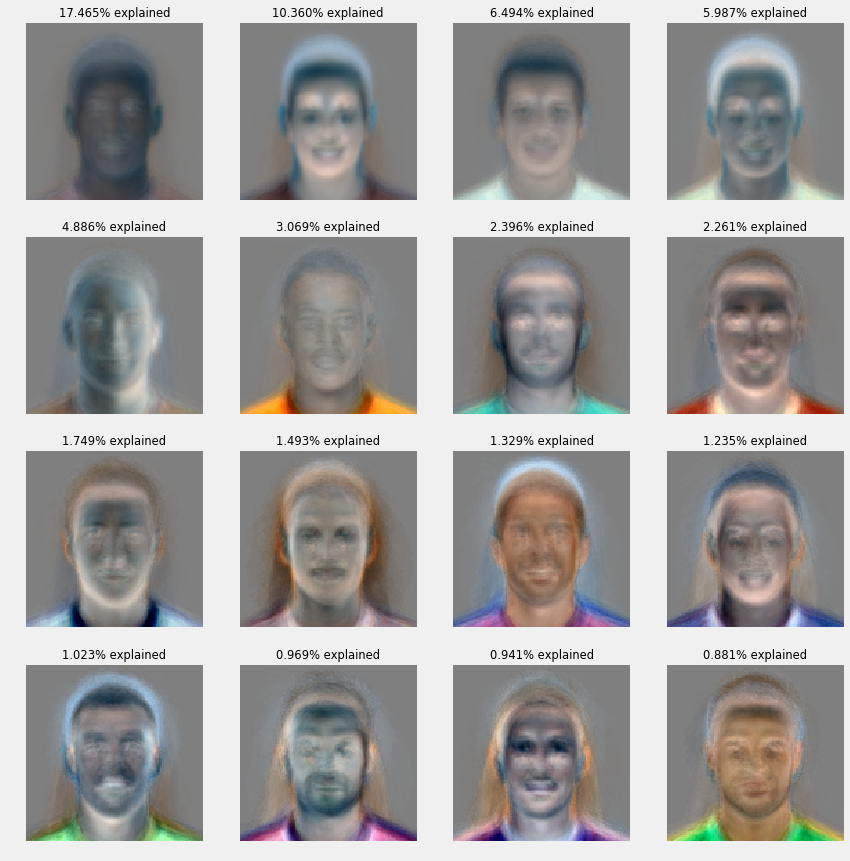

In [8]:
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.figsize'] = (12,12)

face_PCAModel.ShowVarianceDirections(numDirectionsToShow=16)

----------

***NOTE FOR POTENTIAL FORKERS***: if you change "numDirectionsToShow=16" to be for example "numBasisFunctions=32" you will get more eigenvectors. you can fork and play around.

----------


## Lets see how well can a 120 component PCA model reconstruct the original images

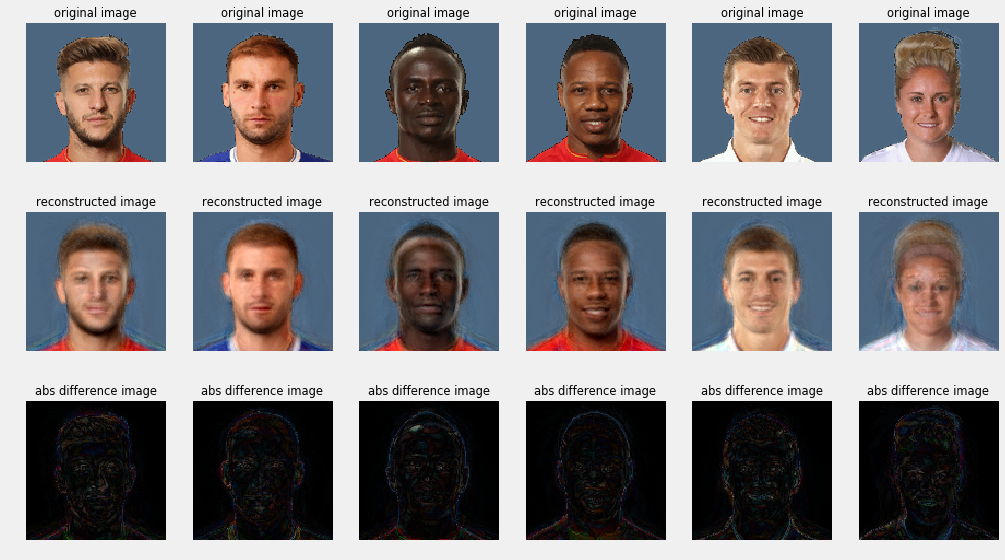

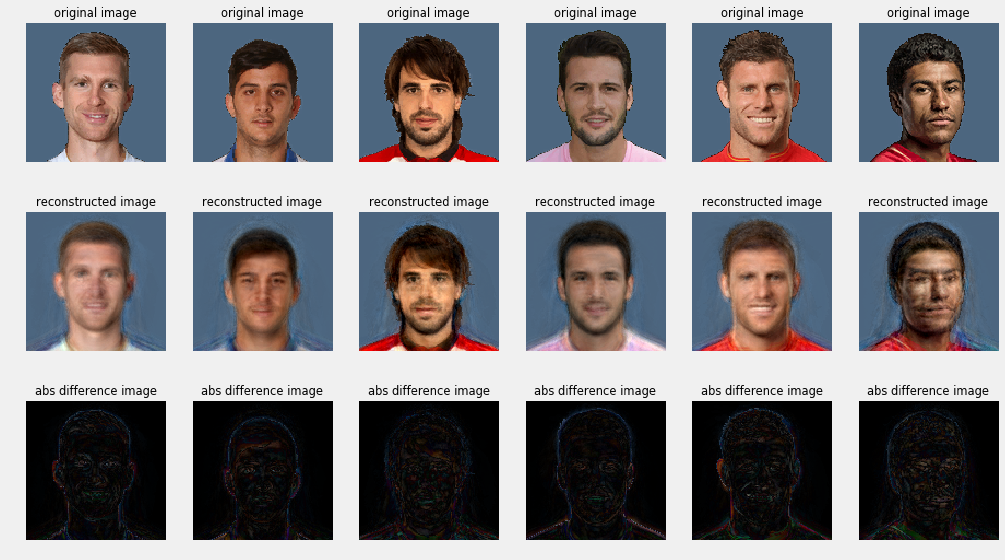

In [9]:
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.figsize'] = (14,8)

face_PCAModel.ShowReconstructions(X, numReconstructions=12)

we can see that by trying to reconstruct original image using a linear combination of only 120 images we are able to get a fairly good reconstruction of players. Usually, the better reconstruction one can get with a fewer number of components implies that there are a lot of dependencies in the data (i.e. a lot of correlated pixels)

----------

## Let's look at how the the face images vary around the mean face image:

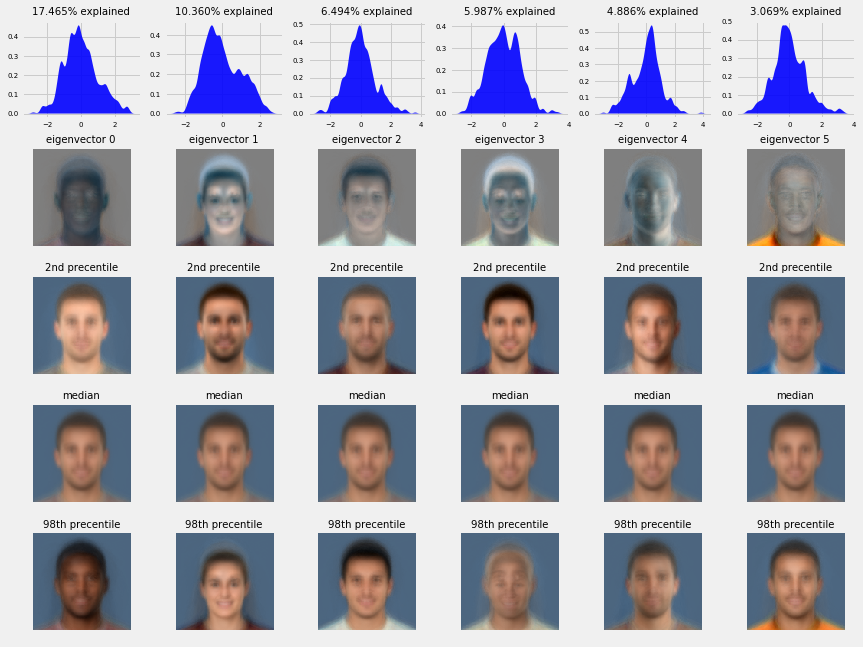

In [10]:
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['figure.figsize'] = (12,9)

face_PCAModel.ShowModelVariations(numVariations=6)

**For those of us unfamiliar with this kind of a plot and since this is quite a busy plot, let me explain what we see:**
------------------------------------------------------------------------
  


----------


 - The upper most row contains the data distributions of each eigenvector (i.e. the histogram along that "direction")
 - The second row contains what we already saw in a previous plot, what we called the variance directions.
 - The forth row contains the median image of leafs. notice that this row is identical for all eigenvectors
 - The third row holds the 2nd percentile images of each eigenvector. it's easier to think of this as the median image minus the eigenvector image multiplied by some constant. i.e the image we see is the forth row image, minus the second row image, when the second row image is multiplied by a constant. The constant is chosen to show the varying degree of influence of this specific eigenvector on the "average" image, so we can visualize what type of variation this particular eigenvector tends to capture. 2nd percentile will subtract a relatively large absolute value from the median image, showing us what images look like when this coefficient is highly negative. 98th percentile would be just the opposite, showing us what images look like when this coefficient is at the upper end of the range. 50th percentile would give us a "middle of the road" effect of this coefficient.


----------


This plot helps us visualize what a direction in this high dimensional image space means. For example:

 - **The first eigenvector** (leftmost column), we can see
   that it **controls the difference between dark skinned players and light skinned players**. i.e we can say that some of the variance along the change of skin color is explained by this component.

 - **The second eigenvector** (second from the left), we can see
   that it **controls the difference between male and female players**. i.e we can say that some of the variance along the change of player sex is explained by this component.

----------

We can now deep deeper into some interesting looking eigenvectors

**Eigenvector 1: dark skinned or light skinned?**
-------------------------------------------------

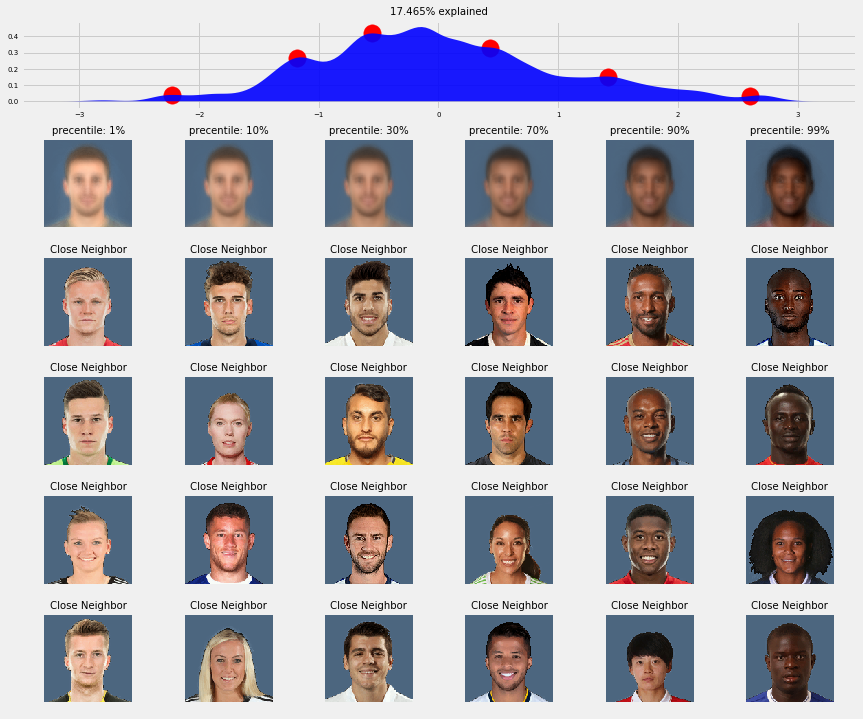

In [11]:
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['figure.figsize'] = (12,10)

face_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[0])

**Let me explain this plot:**

 - at the top row we can see the distribution of the coefficient along
   this particular variance direction.
 - at the second row we can see percentile images that correspond to
   different red dots in the distribution.
 - the four bottom rows contain nearest neighbor images from the data
   itself that are closest to the percentile images above (4 nearest
   neighbors for each percentile image)

----------

**Eigenvector 2: male or female?**
-------------------------------------------

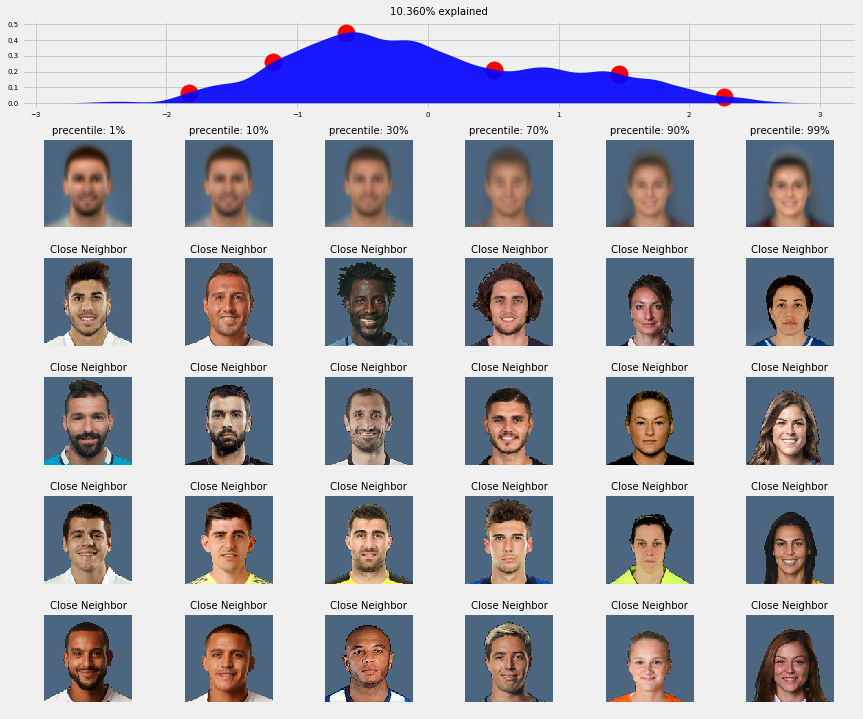

In [12]:
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['figure.figsize'] = (12,10)

face_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[1])

**Eigenvector 11: dim or bright lighting? (perhaps indoor vs outdoor)**
------------------------------------------

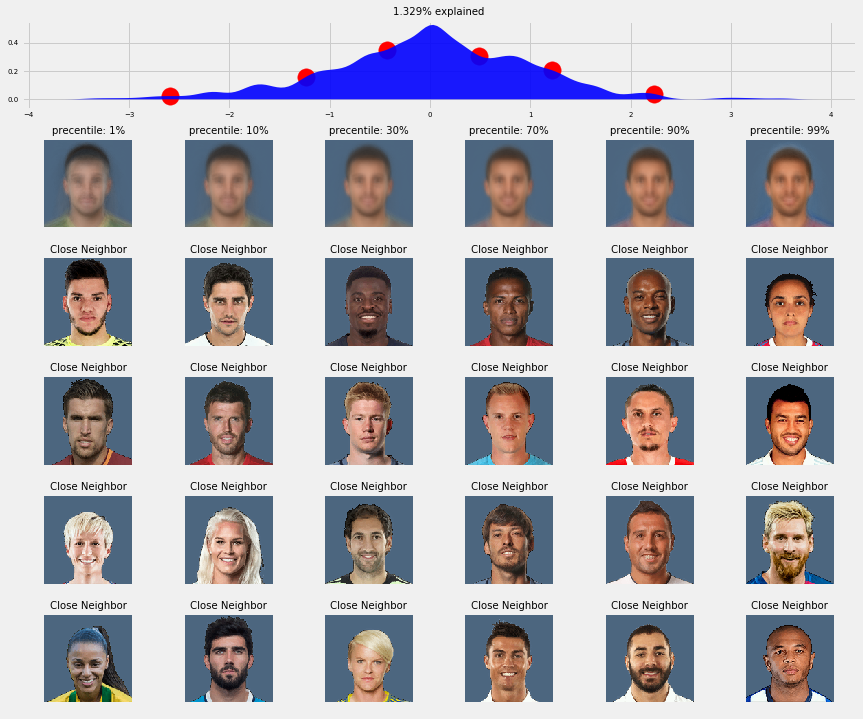

In [13]:
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['figure.figsize'] = (12,10)

face_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[10])

----------

***NOTE FOR POTENTIAL FORKERS***: if you change "listOfComponents=[10]" to be for example "listOfComponents=[10,11,12]" you will get to see these plots for eigenvectors 11,12 and 13. You can fork and play around if you find any interesting components.

----------

Now lets collect some attributes from 'FullData.csv' for the players we have also face images for

In [14]:
#%% for every player that we have a picture for, get his data from "FullData.csv" (if present)
playerData = pd.read_csv('../input/FullData.csv').drop_duplicates(subset='Name', keep='last').reset_index(drop=True)

listOfAllPlayerNames = playerData['Name'].tolist()
recordRowInds = [listOfAllPlayerNames.index(x) if x in listOfAllPlayerNames else 'False' for x in listOfPlayerNames]

desiredColumns = ['Name', 'Nationality', 'Sex', 'Age [years]', 'Height [cm]', 'Weight [kg]']
playerWithPicsData = pd.DataFrame(index=range(len(listOfPlayerNames)),columns=desiredColumns)
playerWithPicsData.loc[:,'Name'] = [x for x in listOfPlayerNames]
playerWithPicsData.loc[:,'Sex']  = ['Female' if x else 'Male' for x in isFemale]

for k, currRowInd in enumerate(recordRowInds):
    if currRowInd != 'False':
        playerWithPicsData.loc[k,'Age [years]'] = float(playerData.loc[currRowInd, 'Age'])
        playerWithPicsData.loc[k,'Height [cm]'] = float(playerData.loc[currRowInd, 'Height'].split(' ')[0])
        playerWithPicsData.loc[k,'Weight [kg]'] = float(playerData.loc[currRowInd, 'Weight'].split(' ')[0])
        playerWithPicsData.loc[k,'Nationality'] = playerData.loc[currRowInd, 'Nationality']
    
# extract face features
faceFeatures = face_PCAModel.RepresentUsingModel(X)

playerWithPicsData.head(10)

,Name,Nationality,Sex,Age [years],Height [cm],Weight [kg]
0,Aaron Ramsey,Wales,Male,26,183,76
1,Adam Lallana,England,Male,28,172,73
2,Adil Rami,France,Male,31,190,88
3,Adn,NaN,Male,NaN,NaN,NaN
4,Adrien Rabiot,France,Male,21,188,71
5,Adrien Silva,Portugal,Male,28,175,69
6,Aduriz,Spain,Male,36,182,78
7,Alan Dzagoev,Russia,Male,26,179,75
8,Alejandro Gmez,NaN,Male,NaN,NaN,NaN
9,Aleksandar Kolarov,Serbia,Male,31,187,83


In [15]:
playerWithPicsData.tail()

,Name,Nationality,Sex,Age [years],Height [cm],Weight [kg]
567,Vivianne Miedema,NaN,Female,NaN,NaN,NaN
568,Wendie Renard,NaN,Female,NaN,NaN,NaN
569,Whitney Engen,NaN,Female,NaN,NaN,NaN
570,Yamile Franco,NaN,Female,NaN,NaN,NaN
571,Yang Li,NaN,Female,NaN,NaN,NaN


## Plot the correlation between different attributes and the different PCA components

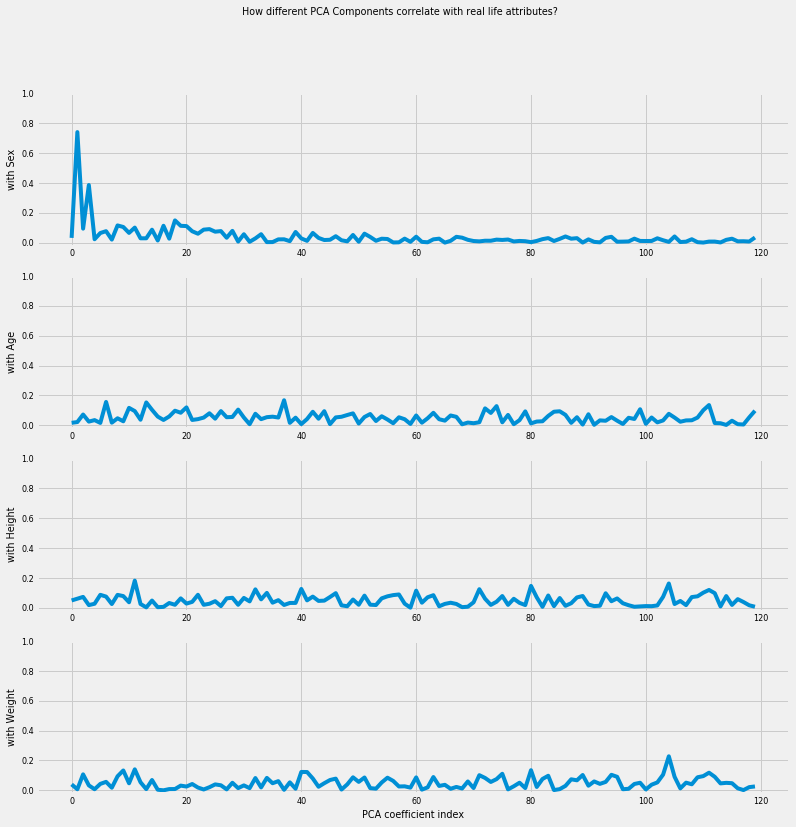

In [16]:
# find the PCA component that most correlates with 'Sex'
releventCols = np.array(playerWithPicsData.loc[:,'Sex'].notnull())
targetFeature = np.array(playerWithPicsData.loc[releventCols,'Sex'] == 'Male')[:,np.newaxis]
corrWithSexVec = np.corrcoef(np.hstack((targetFeature,faceFeatures[releventCols,:])).T)[0,1:]
mostCorrelatedWithSex = np.argmax(abs(corrWithSexVec))

# find the PCA component that most correlates with 'Age'
releventCols = np.array(playerWithPicsData.loc[:,'Age [years]'].notnull())
targetFeature = np.array(playerWithPicsData.loc[releventCols,'Age [years]'].tolist())[:,np.newaxis]
corrWithAgeVec = np.corrcoef(np.hstack((targetFeature,faceFeatures[releventCols,:])).T)[0,1:]
mostCorrelatedWithAge = np.argmax(abs(corrWithAgeVec))

# find the PCA component that most correlates with 'Height'
releventCols = np.array(playerWithPicsData.loc[:,'Height [cm]'].notnull())
targetFeature = np.array(playerWithPicsData.loc[releventCols,'Height [cm]'].tolist())[:,np.newaxis]
corrWithHeightVec = np.corrcoef(np.hstack((targetFeature,faceFeatures[releventCols,:])).T)[0,1:]
mostCorrelatedWithHeight = np.argmax(abs(corrWithHeightVec))

# find the PCA component that most correlates with 'Weight'
releventCols = np.array(playerWithPicsData.loc[:,'Weight [kg]'].notnull())
targetFeature = np.array(playerWithPicsData.loc[releventCols,'Weight [kg]'].tolist())[:,np.newaxis]
corrWithWeightVec = np.corrcoef(np.hstack((targetFeature,faceFeatures[releventCols,:])).T)[0,1:]
mostCorrelatedWithWeight = np.argmax(abs(corrWithWeightVec))

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.figsize'] = (12,12)

plt.figure()
plt.subplot(4,1,1); plt.plot(np.abs(corrWithSexVec)); 
plt.ylim(-0.02,1); plt.ylabel('with Sex')
plt.subplot(4,1,2); plt.plot(np.abs(corrWithAgeVec)); 
plt.ylim(-0.02,1); plt.ylabel('with Age')
plt.subplot(4,1,3); plt.plot(np.abs(corrWithHeightVec)); 
plt.ylim(-0.02,1); plt.ylabel('with Height')
plt.subplot(4,1,4); plt.plot(np.abs(corrWithWeightVec)); 
plt.ylim(-0.02,1); plt.ylabel('with Weight')
plt.xlabel('PCA coefficient index')
plt.suptitle('How different PCA Components correlate with real life attributes?')

We can see that there are **no clear high correlations** except for those that we already previously saw between male and females. **too bad**. 
I suspect we will see some correlations with the Nationality field if we further divide it into continents, but I leave it to you to investigate this if you wish.

----------


To conclude, I hope that the fact that we can use **almost exactly the same code and analysis tools** as in [Visualizing PCA][1] script and get quick a feel for how players look like as well as how leaves look like demonstrates **the incredible power of basic visualization techniques** such as we presented here. I hope everyone reading this will use some of these techniques in the future :-)


  [1]: https://www.kaggle.com/selfishgene/leaf-classification/visualizing-pca-with-leaf-dataset